In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
b = BLEPipeline()

In [4]:
# b.extract_packet_features(create_master=True)

In [5]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


In [6]:
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length", "Time", 
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

## Resample

### Downsampling

In [7]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}
ble_devicetypes = ["door","lock","temp"]

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

### Create trial dataframes

In [8]:
df_trials = []
num_trials = 10
while len(df_trials) != num_trials:
    df_downsampled = b.downsample(X, y, df[df["Set"]=="test"])

    # Ensure that the trial sample contains all features in feature list
    if set(features_list).issubset(set(df_downsampled.columns)):
        df_trials.append(df_downsampled)

## Run trials

In [9]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = b.one_vs_all_classify(trial, [x for x in features_list if x in trial.columns], y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports

In [10]:
df_alloutput = b.store_trial_results(trial_results)

In [11]:
b.create_csv_results('ble', trial_results)

In [12]:
df_performance_device = b.report_metrics_across('Device', df_alloutput)
display(df_performance_device)

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision
lock,0.144109,0.095463,0.035454,0.116118,0.119582,0.044412,0.333416,0.479276,0.177999,0.883882,0.119582,0.044412,0.920685,0.098178,0.036463
door,0.065524,0.044153,0.016398,0.093820,0.100361,0.037273,0.934940,0.043257,0.016065,0.906180,0.100361,0.037273,0.001726,0.001892,0.000703
temp,0.975100,0.007424,0.002757,0.989631,0.007458,0.002770,0.429280,0.417044,0.154886,0.010369,0.007458,0.002770,0.984961,0.014381,0.005341


In [13]:
df_performance_classifier = b.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision
KNN,0.416385,0.403394,0.149817,0.438365,0.396756,0.147351,0.369485,0.376094,0.139678,0.561635,0.396756,0.147351,0.665227,0.475333,0.176534
RF,0.356797,0.450291,0.167234,0.344132,0.460693,0.171097,0.339979,0.450233,0.167213,0.655868,0.460693,0.171097,0.651970,0.470302,0.174666
LDA,0.411552,0.410972,0.152631,0.417072,0.435570,0.161767,0.988173,0.016791,0.006236,0.582928,0.435570,0.161767,0.590176,0.430574,0.159911


### Plot ROC plots, report AUC

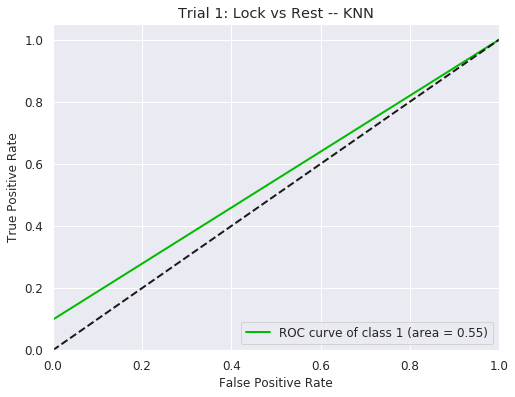

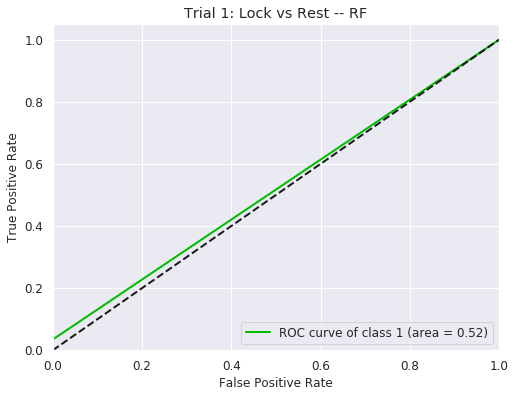

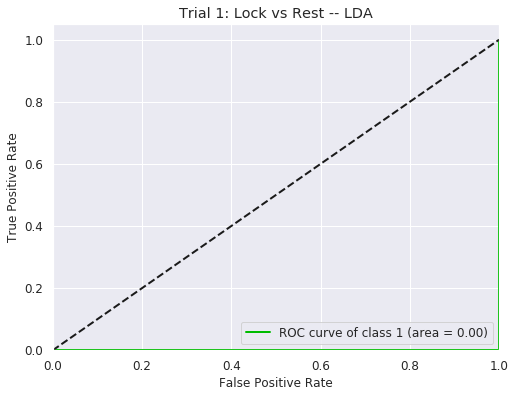

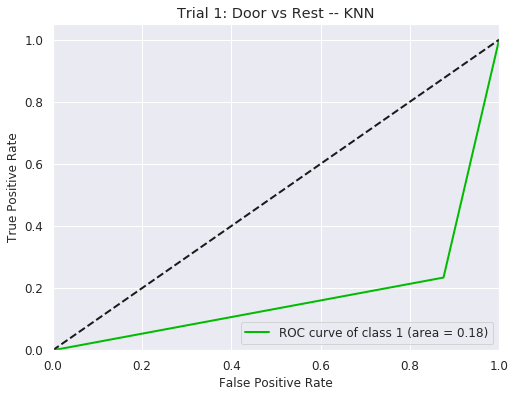

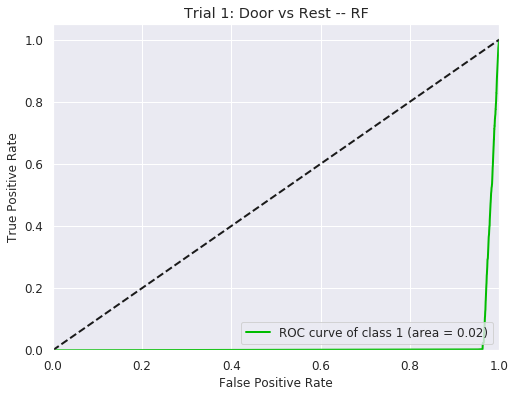

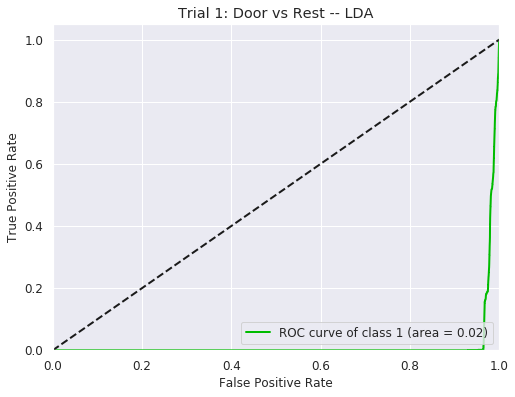

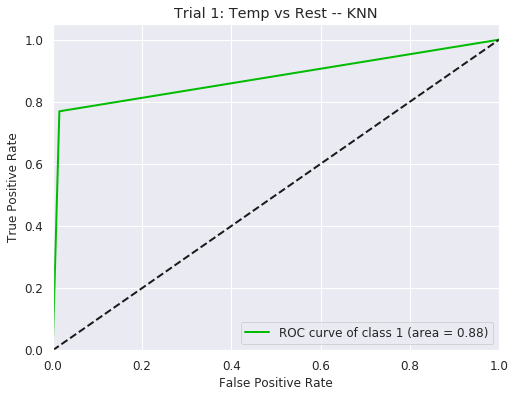

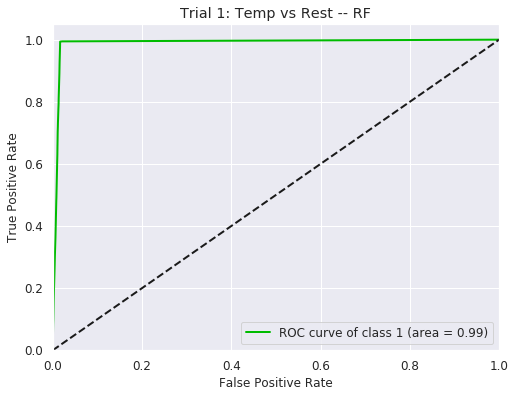

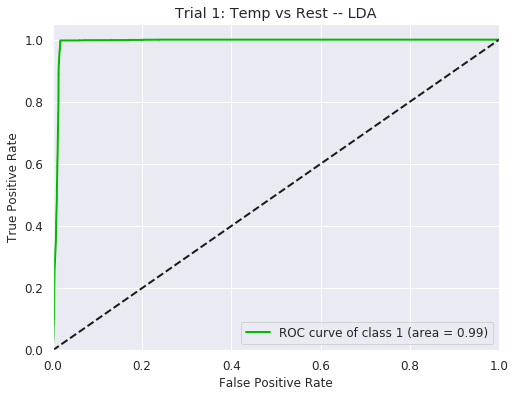

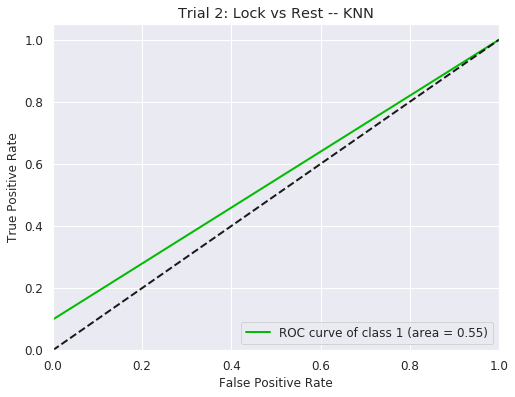

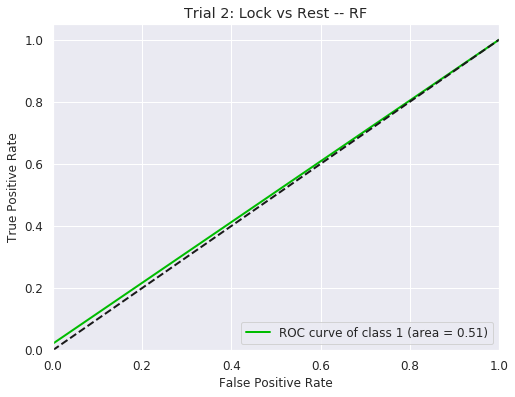

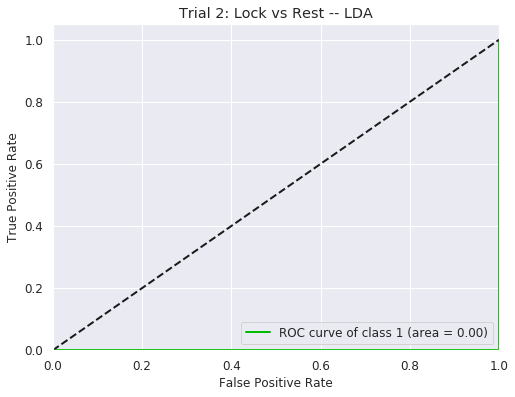

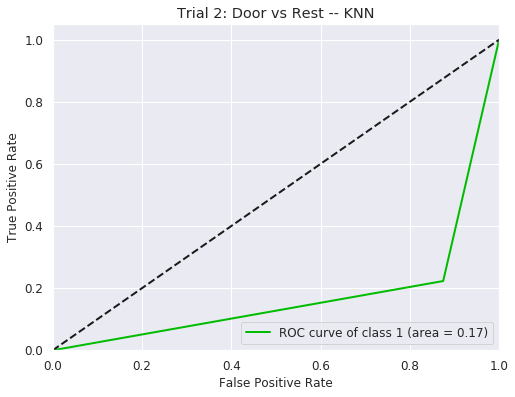

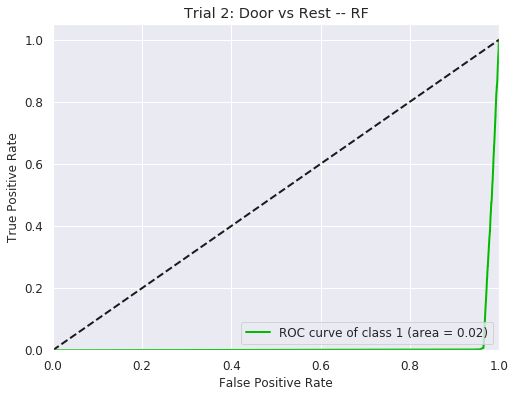

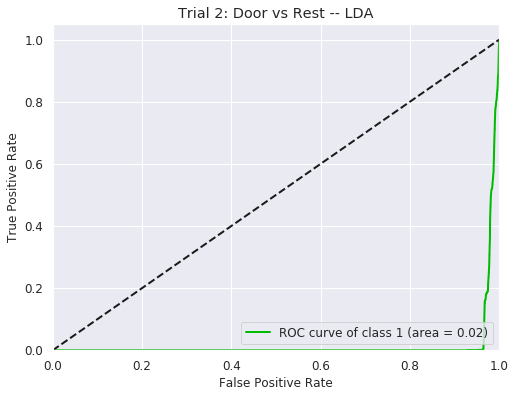

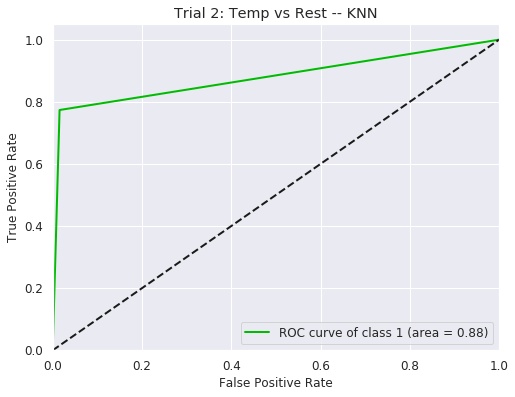

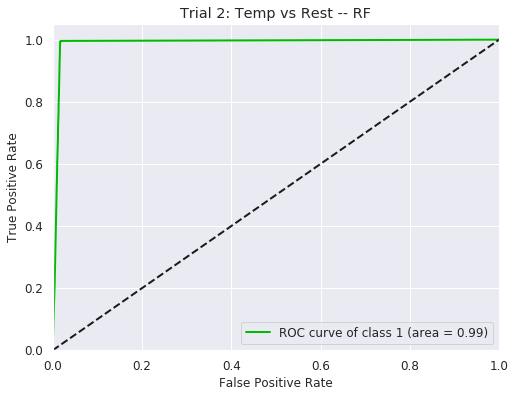

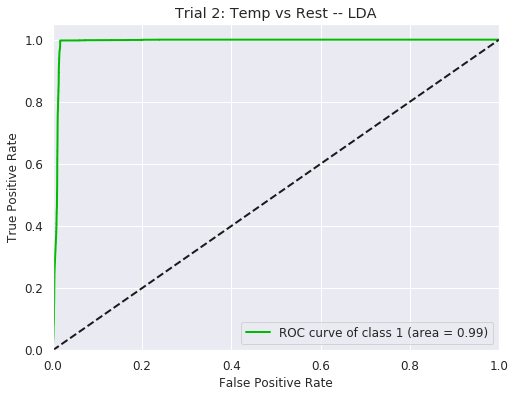

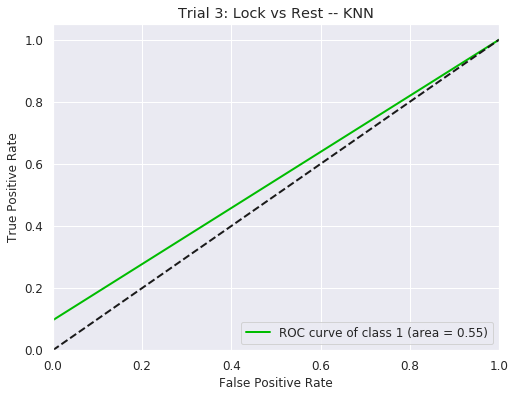

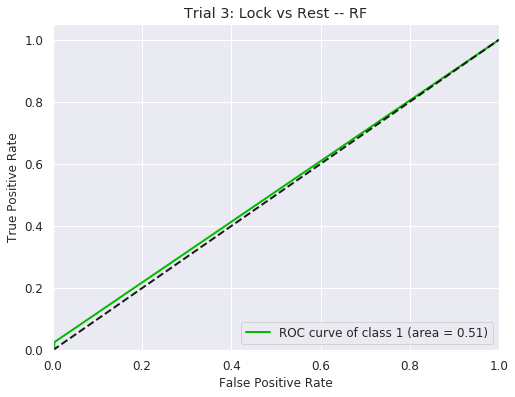

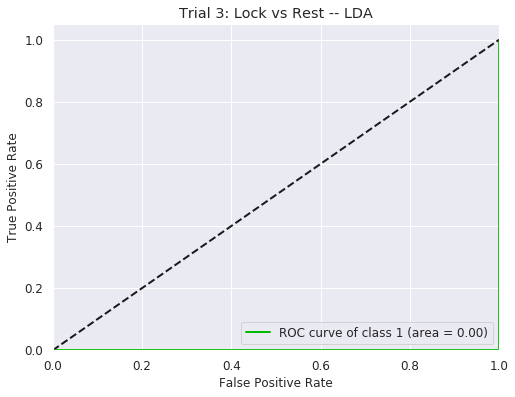

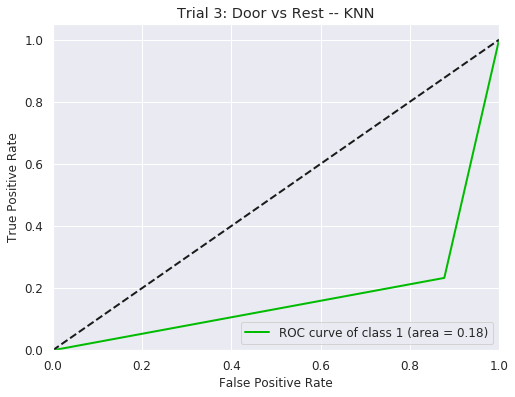

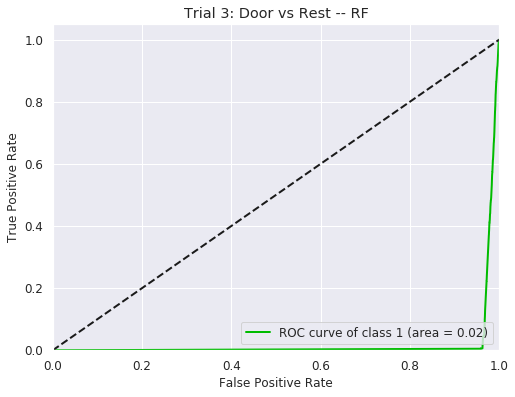

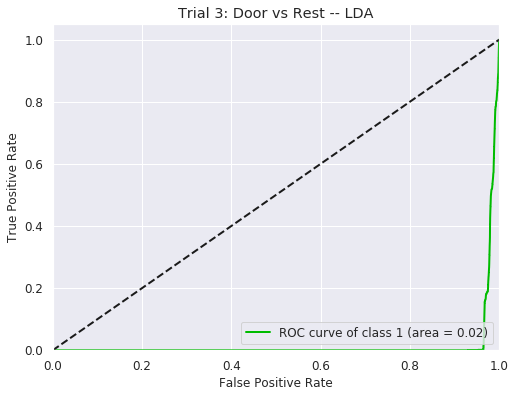

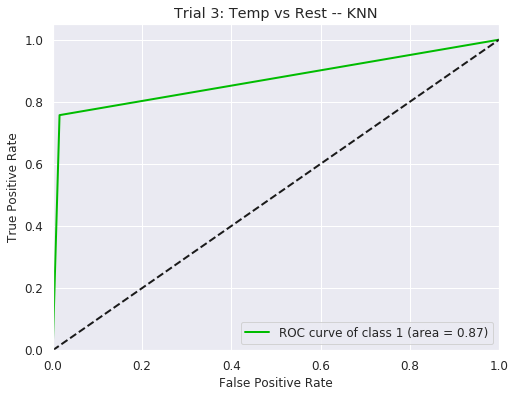

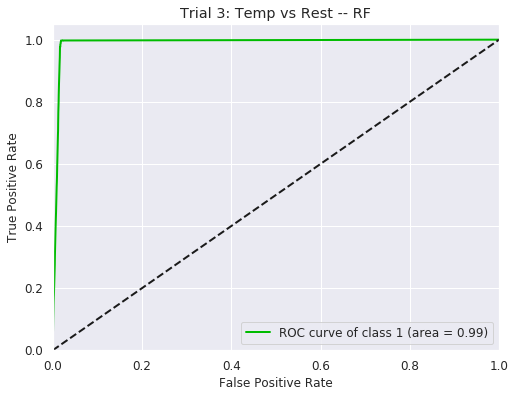

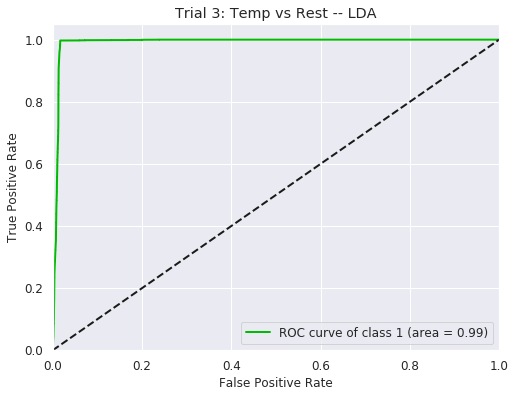

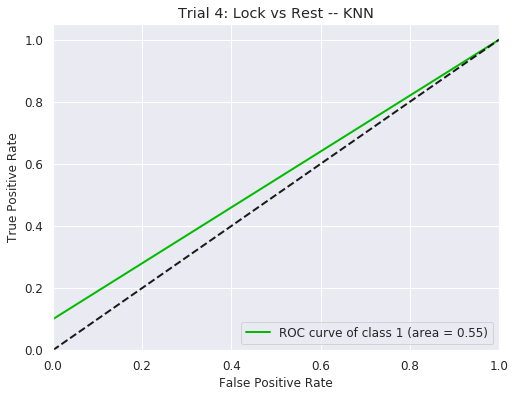

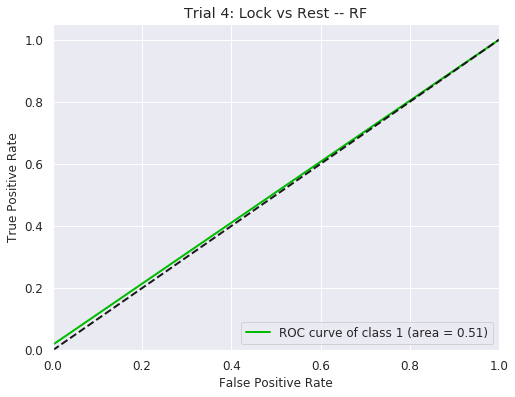

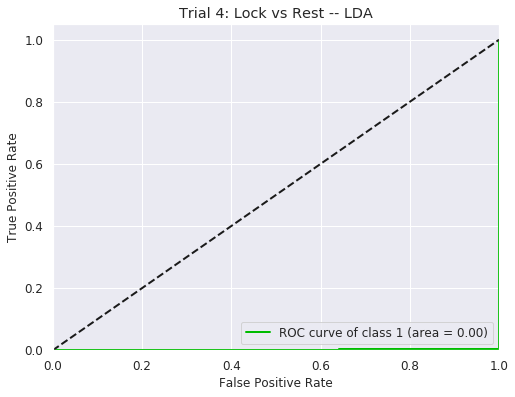

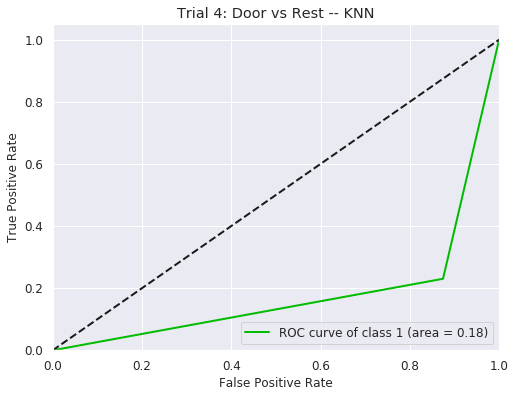

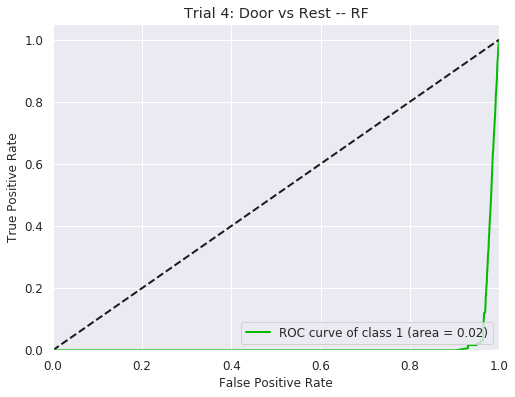

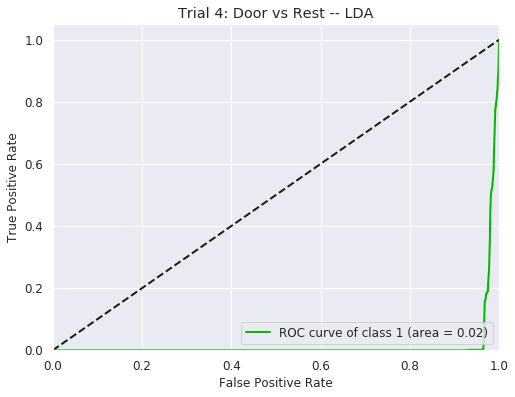

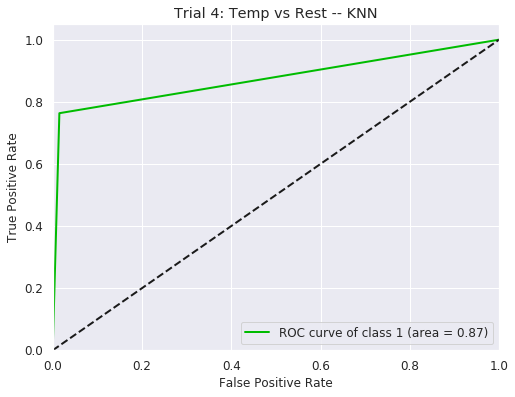

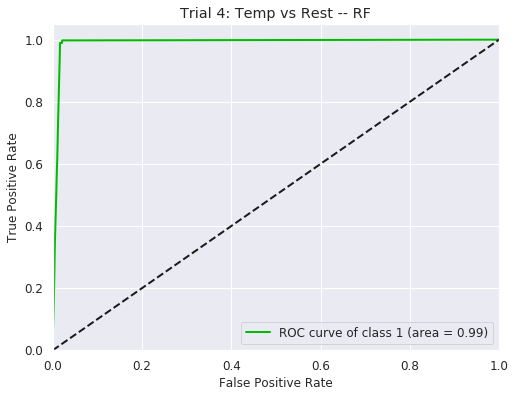

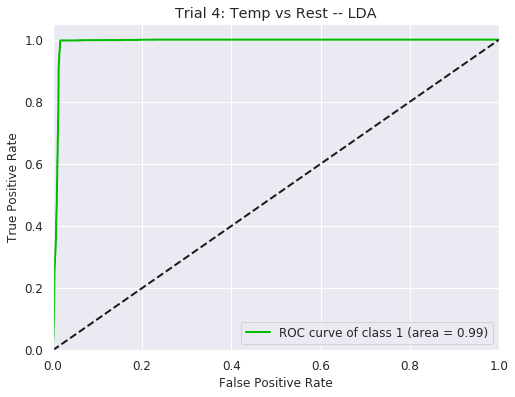

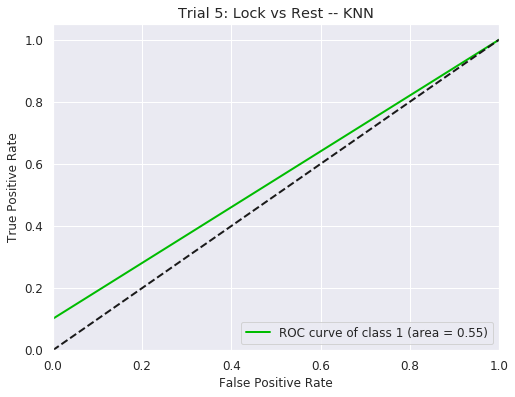

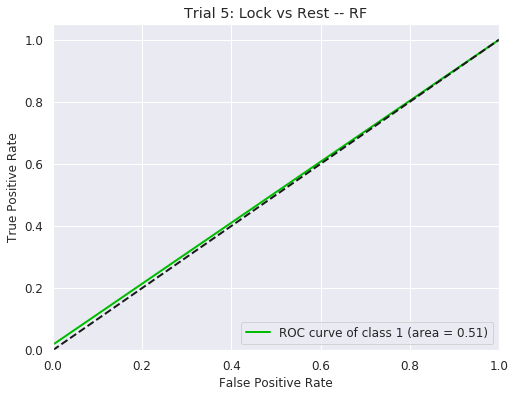

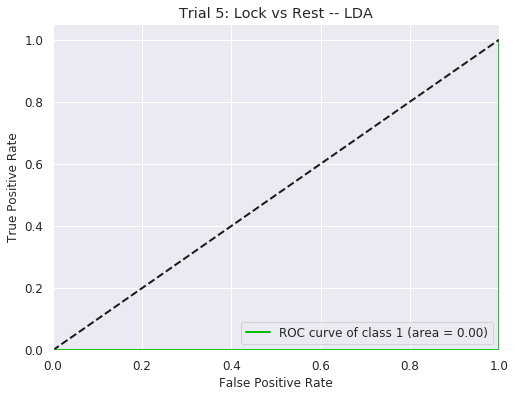

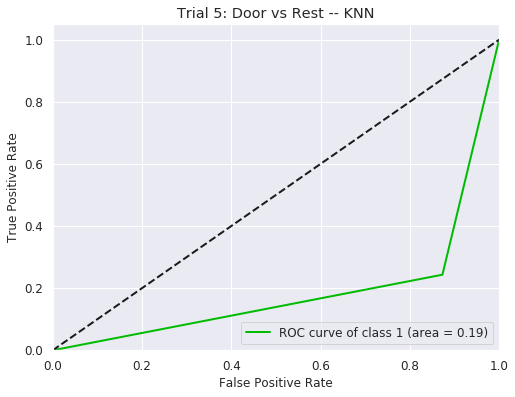

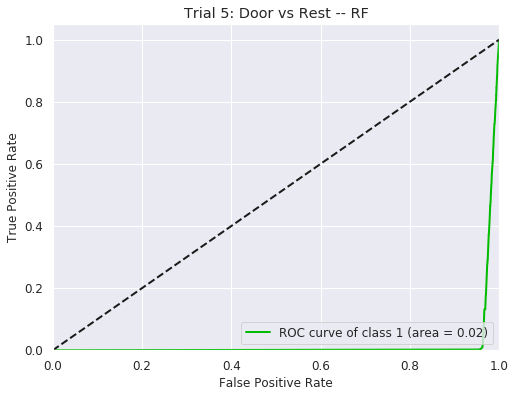

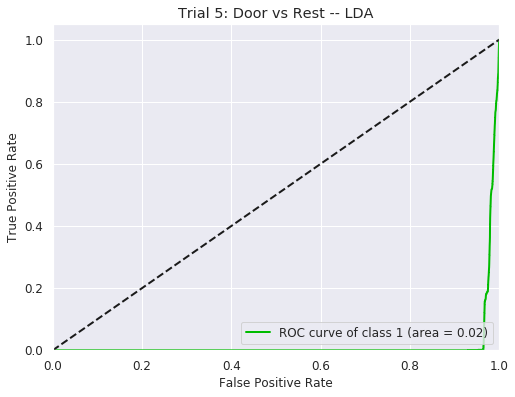

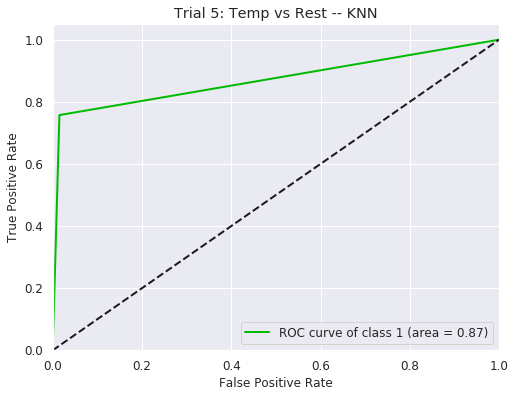

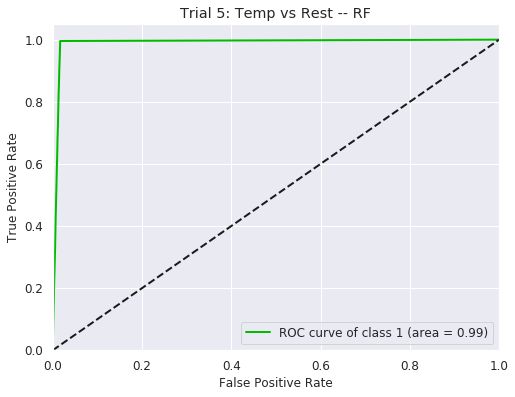

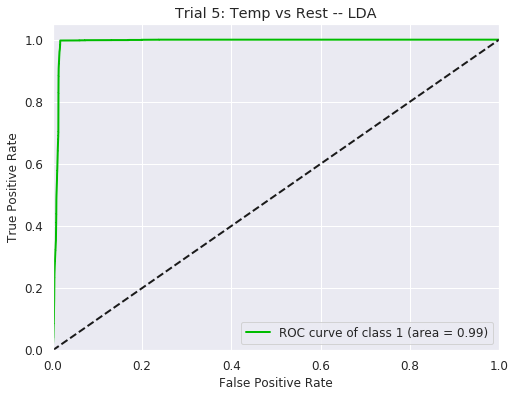

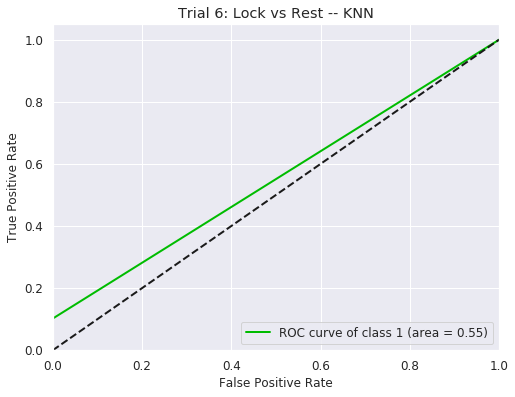

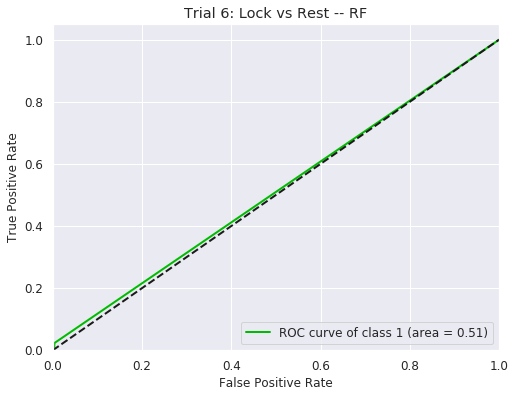

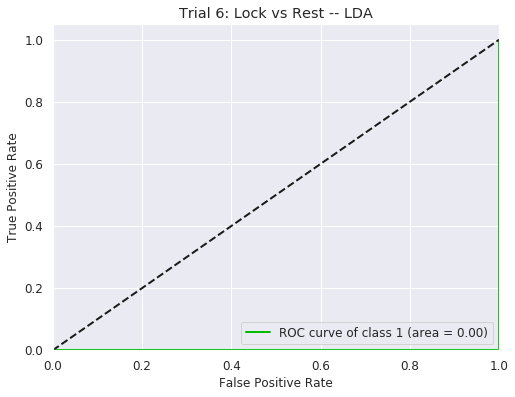

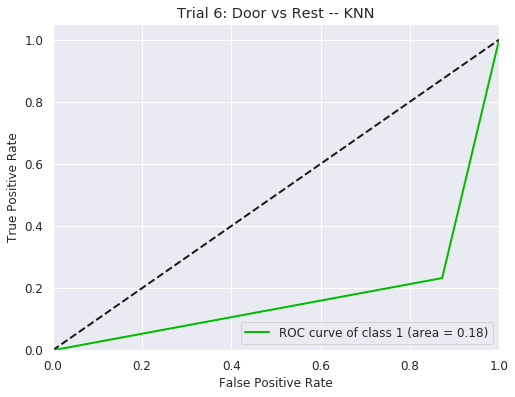

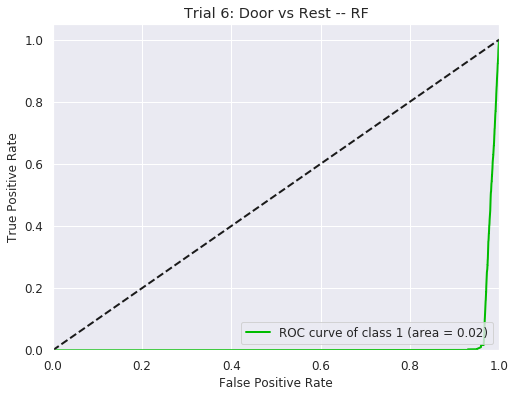

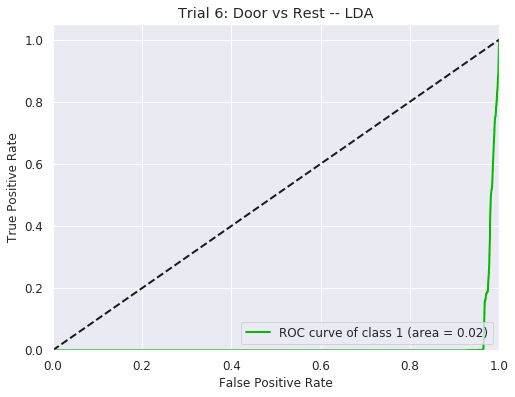

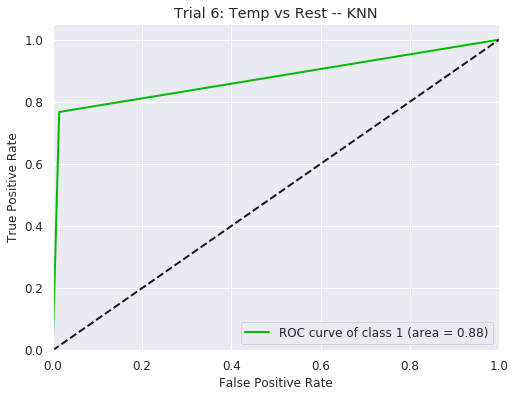

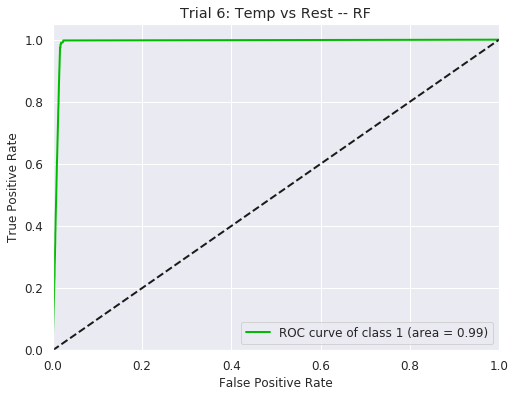

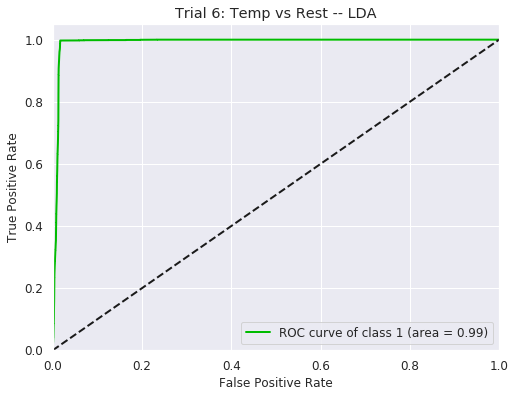

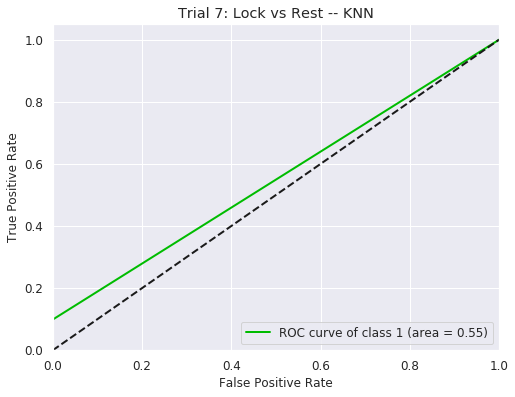

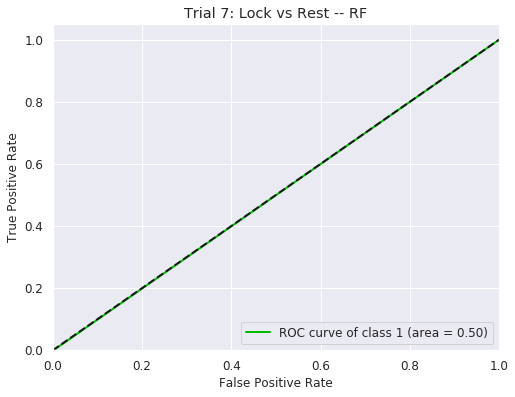

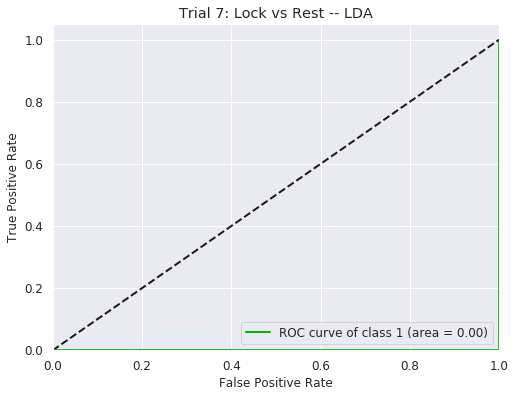

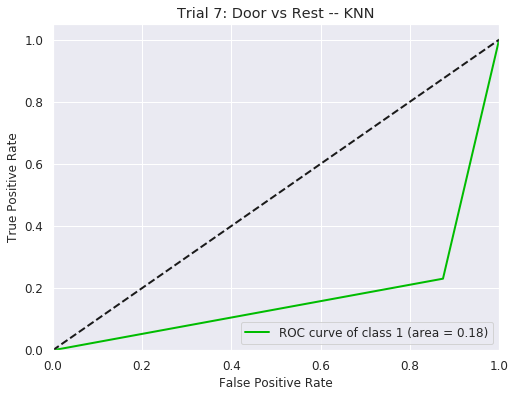

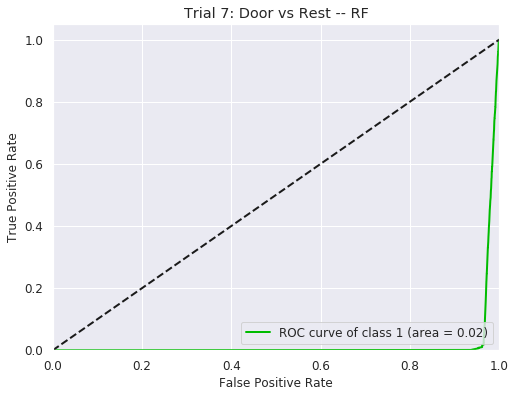

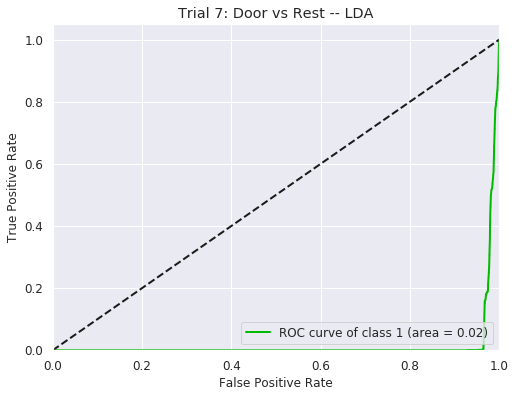

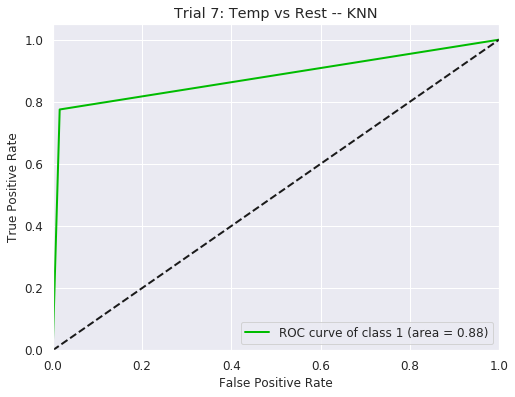

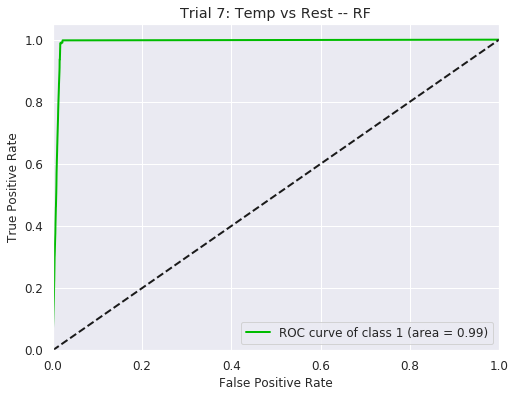

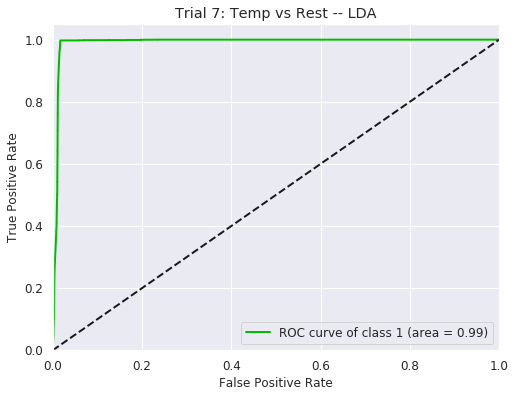

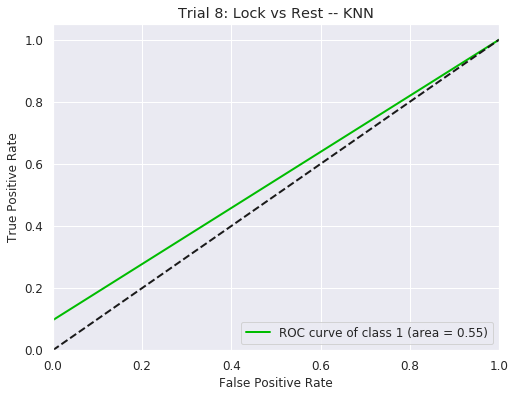

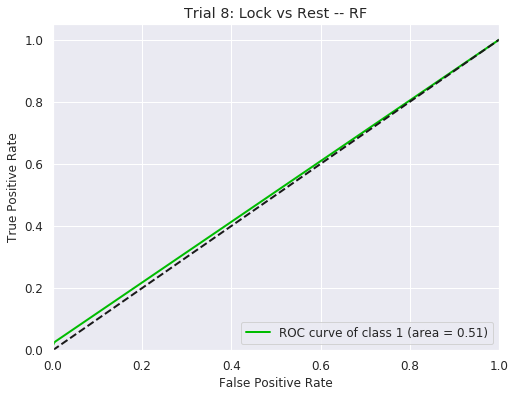

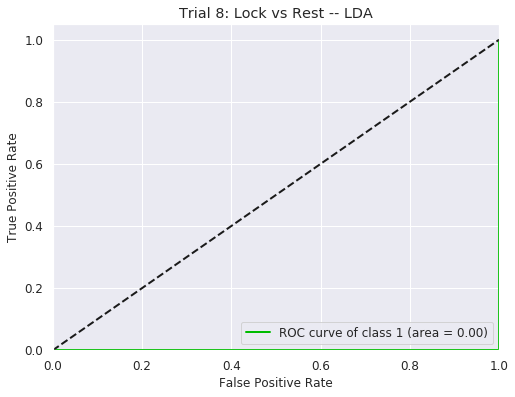

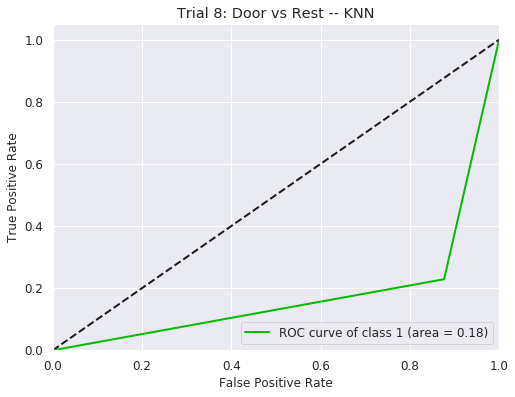

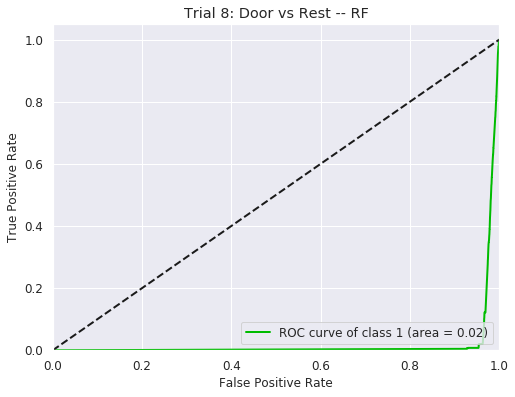

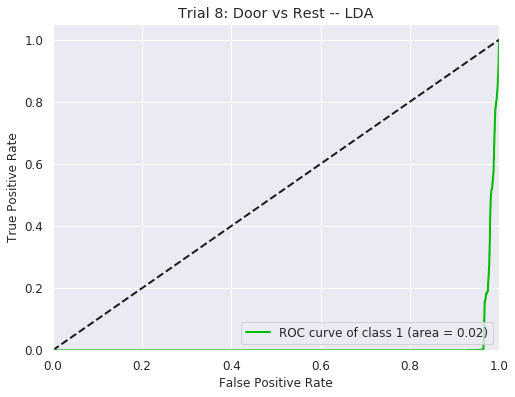

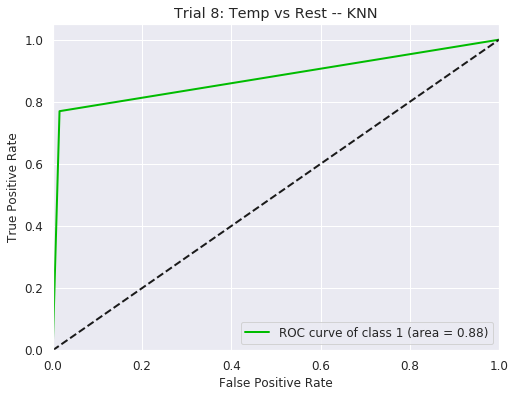

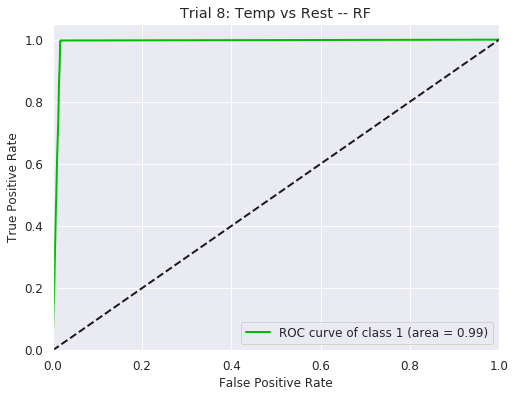

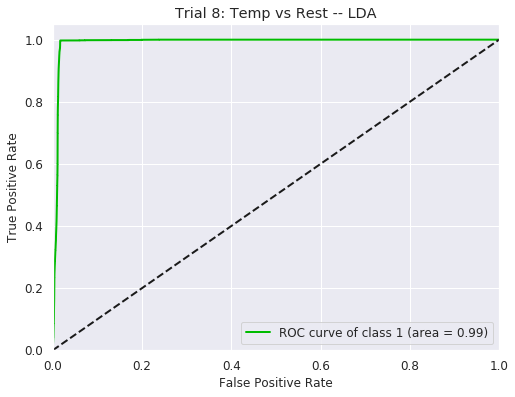

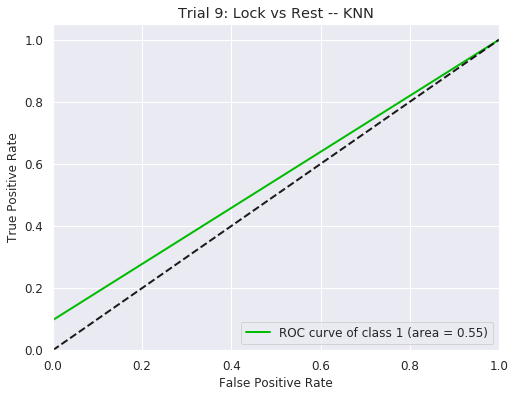

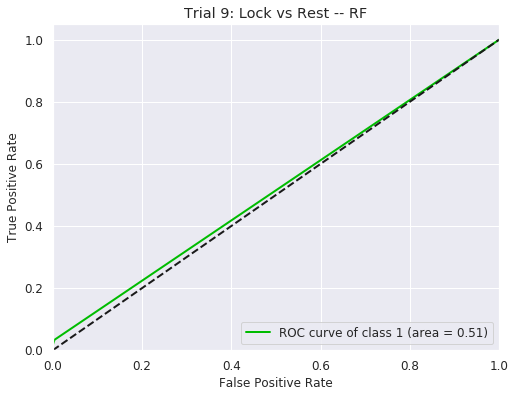

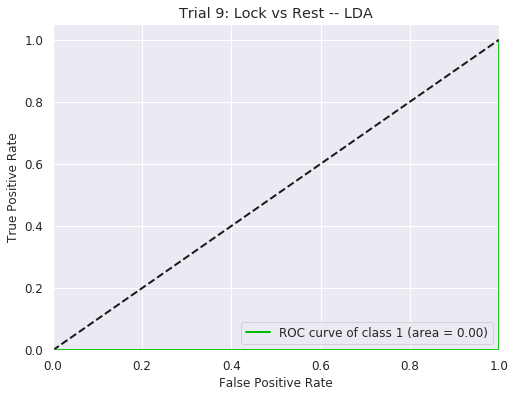

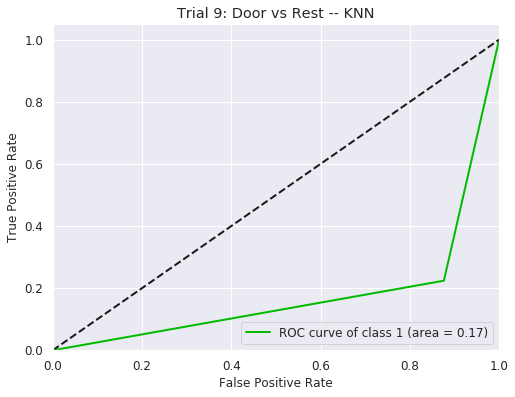

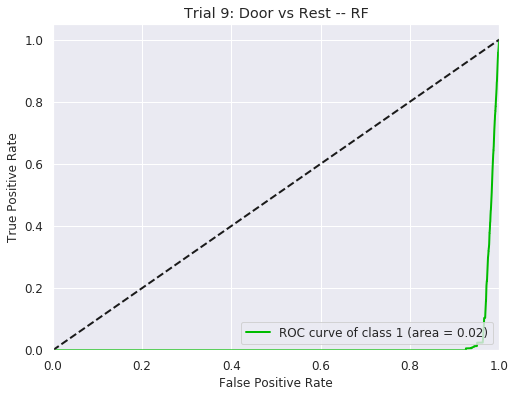

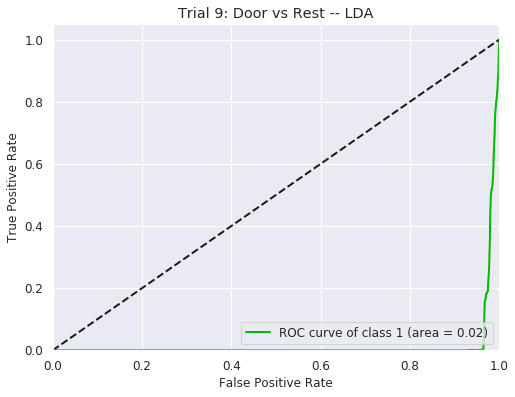

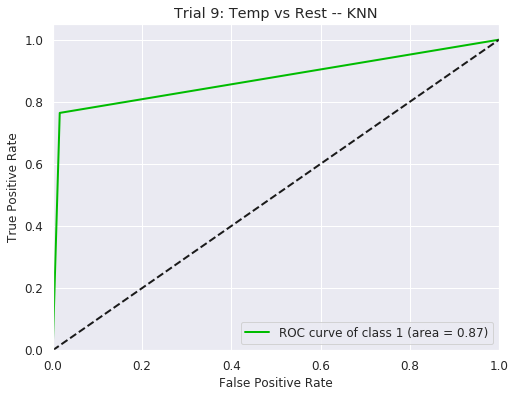

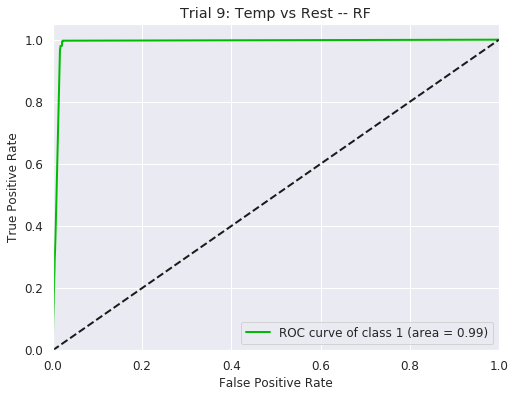

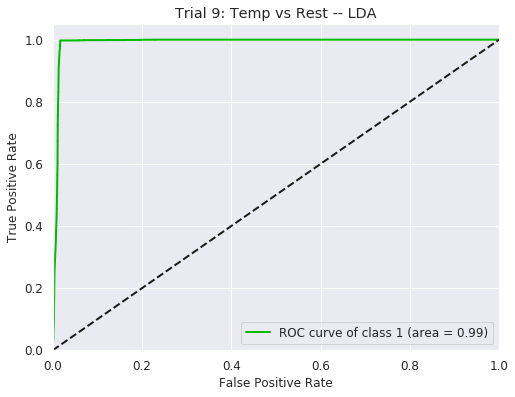

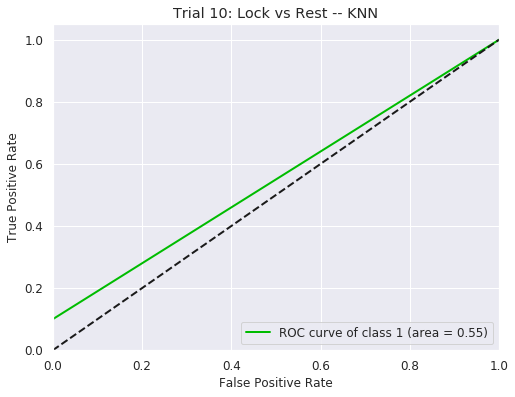

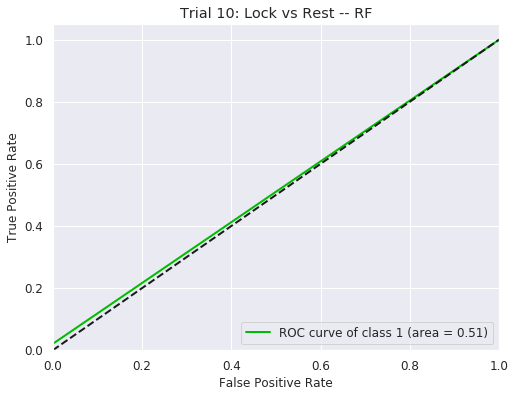

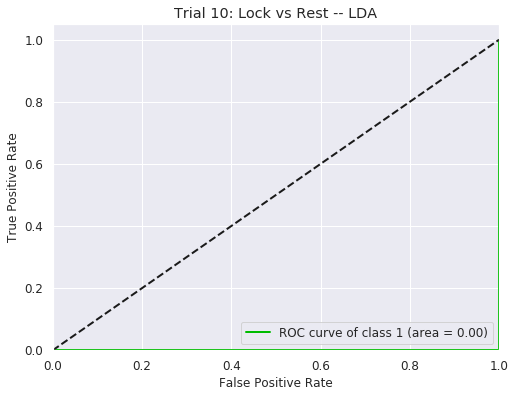

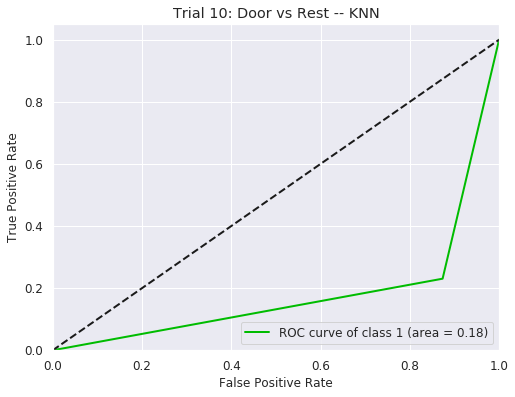

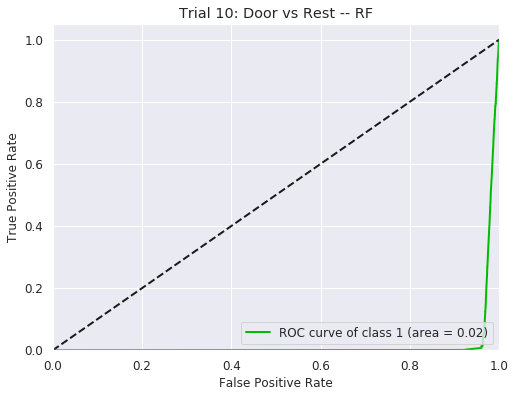

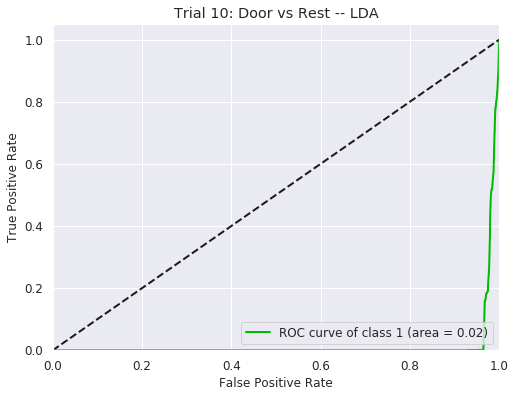

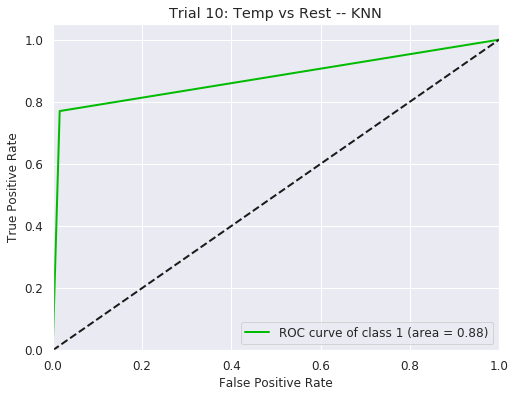

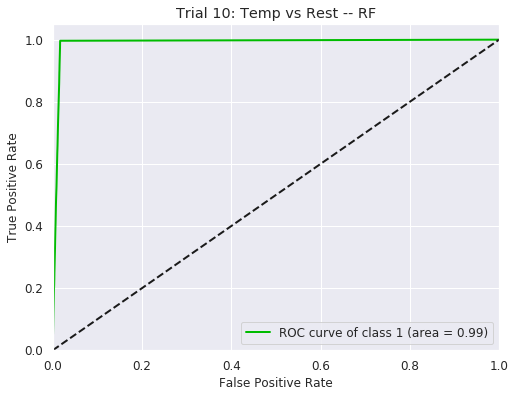

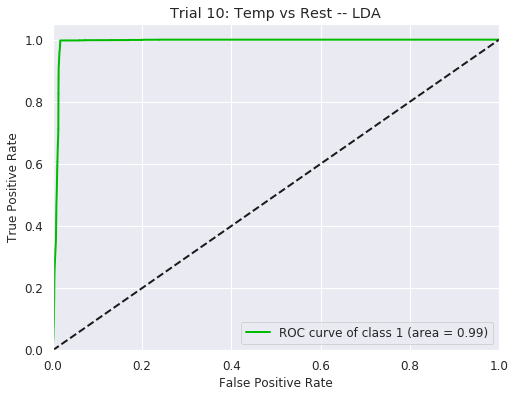

In [15]:
# Plotting ROC curves
sns.set(font_scale=1)

for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()
    
    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Time Performance

In [16]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in y_list:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 24.2132799625 seconds
(Door, KNN) : 5.10482192039 seconds
(Door, RF) : 1.29678702354 seconds
(Door, LDA) : 0.688148021698 seconds
(Lock, KNN) : 4.88671088219 seconds
(Lock, RF) : 1.2401239872 seconds
(Lock, LDA) : 0.654634952545 seconds
(Temp, KNN) : 4.77087688446 seconds
(Temp, RF) : 1.16128802299 seconds
(Temp, LDA) : 0.654325962067 seconds

Trial  1
Total time: 23.8657460213 seconds
(Door, KNN) : 4.88134598732 seconds
(Door, RF) : 1.26943898201 seconds
(Door, LDA) : 0.660310983658 seconds
(Lock, KNN) : 4.79266500473 seconds
(Lock, RF) : 1.13077092171 seconds
(Lock, LDA) : 0.645998954773 seconds
(Temp, KNN) : 4.96642494202 seconds
(Temp, RF) : 1.15015697479 seconds
(Temp, LDA) : 0.648030996323 seconds

Trial  2
Total time: 24.6199388504 seconds
(Door, KNN) : 4.92746400833 seconds
(Door, RF) : 1.36691188812 seconds
(Door, LDA) : 0.673588037491 seconds
(Lock, KNN) : 4.99197888374 seconds
(Lock, RF) : 1.15039587021 seconds
(Lock, LDA) : 0.765799999237 seconds
(Temp,

### Feature Importance

In [17]:
df_featImp = pd.DataFrame()
for i,f in enumerate(b.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [18]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_MOE'] = (2*df_featImp['StdDev']) / np.sqrt(len(df_featImp)-1)

In [19]:
display(df_featImp[['Mean', 'StdDev', 'CI_MOE']].sort_values('Mean', ascending=False))

,Mean,StdDev,CI_MOE
PacketLength,0.297413,0.171479,0.099004
BLE_LL_Length,0.247434,0.109975,0.063494
SCAN_RSP,0.196452,0.142840,0.082469
Assoc_Packets,0.156625,0.086568,0.049980
ADV_IND,0.078142,0.059076,0.034108
SCAN_REQ,0.016873,0.018038,0.010414
Time,0.006012,0.003478,0.002008
Channel_39,0.000430,0.000885,0.000511
Channel_12,0.000411,0.000779,0.000450
Channel_0,0.000110,0.000127,0.000073


### Plots

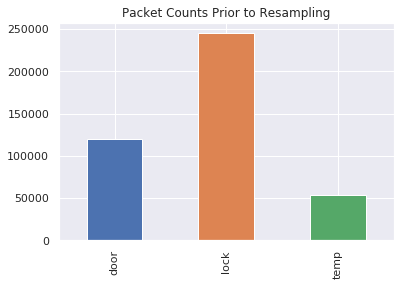

In [20]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

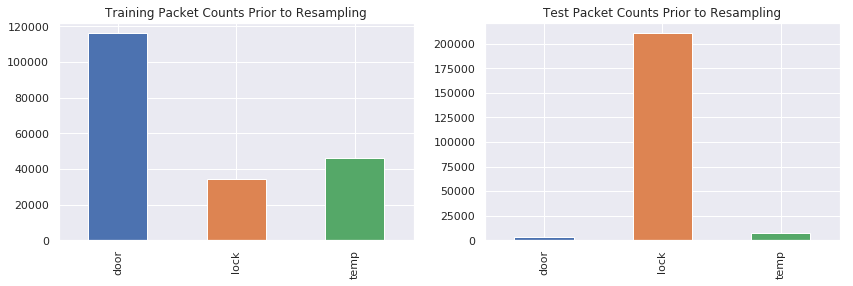

In [21]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


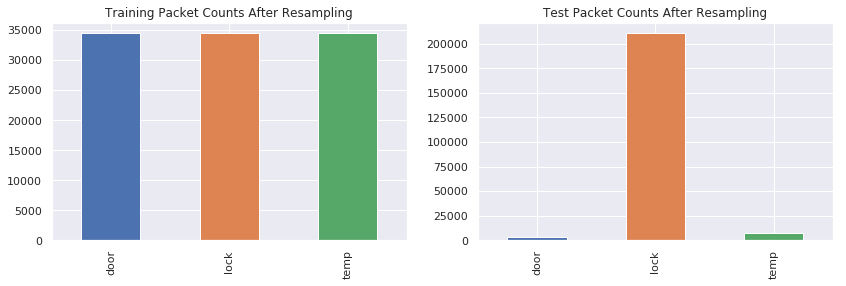

In [22]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[ble_devicetypes].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
